##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

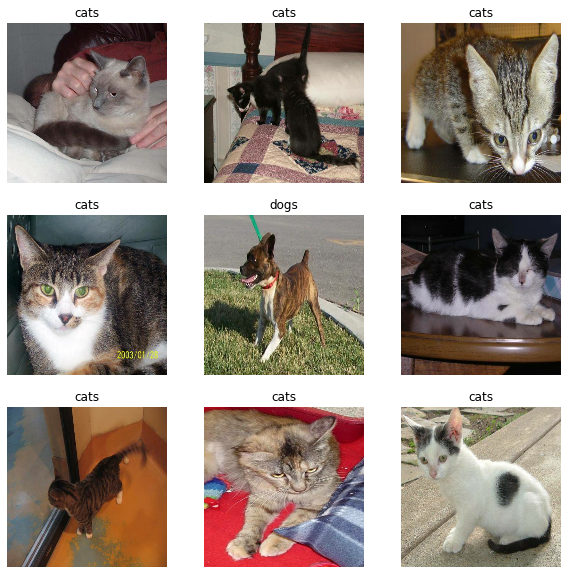

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

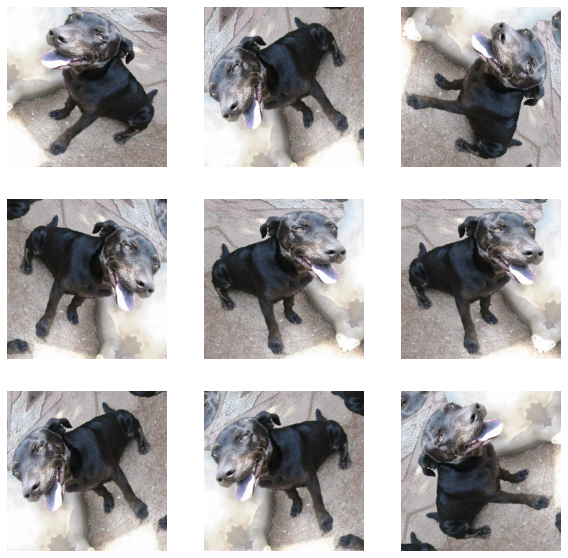

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [13]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 11s 297ms/step - loss: 0.6082 - accuracy: 0.6087


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.60
initial accuracy: 0.62


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 39s 534ms/step - loss: 0.5702 - accuracy: 0.6675 - val_loss: 0.4159 - val_accuracy: 0.7413
Epoch 2/10
63/63 [==============================] - 35s 545ms/step - loss: 0.4455 - accuracy: 0.7705 - val_loss: 0.3183 - val_accuracy: 0.8280
Epoch 3/10
63/63 [==============================] - 35s 540ms/step - loss: 0.3611 - accuracy: 0.8285 - val_loss: 0.2586 - val_accuracy: 0.8725
Epoch 4/10
63/63 [==============================] - 35s 533ms/step - loss: 0.3149 - accuracy: 0.8560 - val_loss: 0.2136 - val_accuracy: 0.9035
Epoch 5/10
63/63 [==============================] - 34s 525ms/step - loss: 0.2883 - accuracy: 0.8690 - val_loss: 0.1861 - val_accuracy: 0.9307
Epoch 6/10
63/63 [==============================] - 36s 548ms/step - loss: 0.2589 - accuracy: 0.8855 - val_loss: 0.1696 - val_accuracy: 0.9369
Epoch 7/10
63/63 [==============================] - 36s 550ms/step - loss: 0.2457 - accuracy: 0.8940 - val_loss: 0.1479 - val_accuracy: 0.9505

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

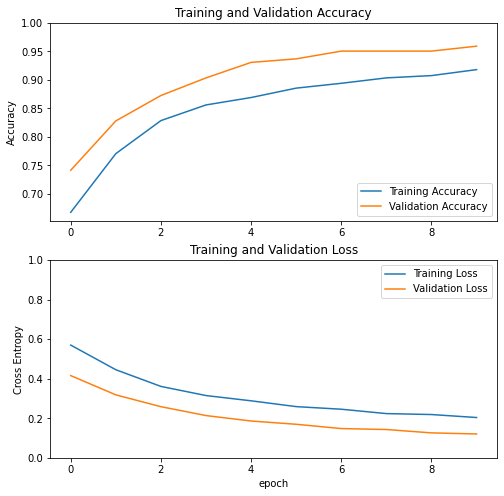

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [32]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 3:59 - loss: 0.1641 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 1s - loss: 0.1724 - accuracy: 0.9375  

 5/63 [=>............................] - ETA: 1s - loss: 0.1708 - accuracy: 0.9362

 7/63 [==>...........................] - ETA: 1s - loss: 0.1718 - accuracy: 0.9332

 9/63 [===>..........................] - ETA: 1s - loss: 0.1710 - accuracy: 0.9329

11/63 [====>.........................] - ETA: 1s - loss: 0.1704 - accuracy: 0.9330

13/63 [=====>........................] - ETA: 1s - loss: 0.1716 - accuracy: 0.9327

15/63 [======>.......................] - ETA: 1s - loss: 0.1722 - accuracy: 0.9330

17/63 [=======>......................] - ETA: 1s - loss: 0.1716 - accuracy: 0.9337

19/63 [========>.....................] - ETA: 1s - loss: 0.1708 - accuracy: 0.9343

21/63 [=========>....................] - ETA: 1s - loss: 0.1716 - accuracy: 0.9337

23/63 [=========>....................] - ETA: 1s - loss: 0.1719 - accuracy: 0.9333

25/63 [==========>...................] - ETA: 1s - loss: 0.1718 - accuracy: 0.9331

27/63 [===========>..................] - ETA: 1s - loss: 0.1716 - accuracy: 0.9330

29/63 [============>.................] - ETA: 1s - loss: 0.1713 - accuracy: 0.9329

31/63 [=============>................] - ETA: 0s - loss: 0.1710 - accuracy: 0.9329

33/63 [==============>...............] - ETA: 0s - loss: 0.1710 - accuracy: 0.9329

35/63 [===============>..............] - ETA: 0s - loss: 0.1708 - accuracy: 0.9328

37/63 [================>.............] - ETA: 0s - loss: 0.1706 - accuracy: 0.9328

39/63 [=================>............] - ETA: 0s - loss: 0.1705 - accuracy: 0.9327

41/63 [==================>...........] - ETA: 0s - loss: 0.1701 - accuracy: 0.9329

43/63 [===================>..........] - ETA: 0s - loss: 0.1699 - accuracy: 0.9329

45/63 [====================>.........] - ETA: 0s - loss: 0.1697 - accuracy: 0.9329

47/63 [=====================>........] - ETA: 0s - loss: 0.1694 - accuracy: 0.9329

49/63 [======================>.......] - ETA: 0s - loss: 0.1692 - accuracy: 0.9329

51/63 [=======================>......] - ETA: 0s - loss: 0.1689 - accuracy: 0.9330

53/63 [========================>.....] - ETA: 0s - loss: 0.1685 - accuracy: 0.9331

56/63 [=========================>....] - ETA: 0s - loss: 0.1680 - accuracy: 0.9333

59/63 [===========================>..] - ETA: 0s - loss: 0.1675 - accuracy: 0.9334

62/63 [============================>.] - ETA: 0s - loss: 0.1669 - accuracy: 0.9336

63/63 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.9337

63/63 [==============================] - 8s 60ms/step - loss: 0.1665 - accuracy: 0.9338 - val_loss: 0.0613 - val_accuracy: 0.9715


Epoch 11/20


 1/63 [..............................] - ETA: 19s - loss: 0.1245 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.1052 - accuracy: 0.9740 

 5/63 [=>............................] - ETA: 2s - loss: 0.1064 - accuracy: 0.9663

 7/63 [==>...........................] - ETA: 1s - loss: 0.1056 - accuracy: 0.9642

 9/63 [===>..........................] - ETA: 1s - loss: 0.1073 - accuracy: 0.9624

11/63 [====>.........................] - ETA: 1s - loss: 0.1069 - accuracy: 0.9622

13/63 [=====>........................] - ETA: 1s - loss: 0.1072 - accuracy: 0.9617

15/63 [======>.......................] - ETA: 1s - loss: 0.1105 - accuracy: 0.9593

17/63 [=======>......................] - ETA: 1s - loss: 0.1124 - accuracy: 0.9575

19/63 [========>.....................] - ETA: 1s - loss: 0.1136 - accuracy: 0.9561

21/63 [=========>....................] - ETA: 1s - loss: 0.1143 - accuracy: 0.9551

23/63 [=========>....................] - ETA: 1s - loss: 0.1150 - accuracy: 0.9543

25/63 [==========>...................] - ETA: 1s - loss: 0.1157 - accuracy: 0.9535

27/63 [===========>..................] - ETA: 1s - loss: 0.1163 - accuracy: 0.9527

29/63 [============>.................] - ETA: 1s - loss: 0.1168 - accuracy: 0.9521

31/63 [=============>................] - ETA: 1s - loss: 0.1174 - accuracy: 0.9515

33/63 [==============>...............] - ETA: 1s - loss: 0.1179 - accuracy: 0.9510

35/63 [===============>..............] - ETA: 0s - loss: 0.1183 - accuracy: 0.9506

37/63 [================>.............] - ETA: 0s - loss: 0.1187 - accuracy: 0.9502

39/63 [=================>............] - ETA: 0s - loss: 0.1189 - accuracy: 0.9500

41/63 [==================>...........] - ETA: 0s - loss: 0.1190 - accuracy: 0.9498

43/63 [===================>..........] - ETA: 0s - loss: 0.1192 - accuracy: 0.9496

45/63 [====================>.........] - ETA: 0s - loss: 0.1193 - accuracy: 0.9495

47/63 [=====================>........] - ETA: 0s - loss: 0.1195 - accuracy: 0.9493

49/63 [======================>.......] - ETA: 0s - loss: 0.1195 - accuracy: 0.9493

51/63 [=======================>......] - ETA: 0s - loss: 0.1196 - accuracy: 0.9492

53/63 [========================>.....] - ETA: 0s - loss: 0.1197 - accuracy: 0.9492

55/63 [=========================>....] - ETA: 0s - loss: 0.1199 - accuracy: 0.9491

58/63 [==========================>...] - ETA: 0s - loss: 0.1200 - accuracy: 0.9490

61/63 [============================>.] - ETA: 0s - loss: 0.1201 - accuracy: 0.9489

63/63 [==============================] - 3s 50ms/step - loss: 0.1202 - accuracy: 0.9489 - val_loss: 0.0597 - val_accuracy: 0.9703


Epoch 12/20


 1/63 [..............................] - ETA: 17s - loss: 0.2390 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.1870 - accuracy: 0.9253 

 5/63 [=>............................] - ETA: 1s - loss: 0.1564 - accuracy: 0.9358

 7/63 [==>...........................] - ETA: 1s - loss: 0.1388 - accuracy: 0.9425

 9/63 [===>..........................] - ETA: 1s - loss: 0.1290 - accuracy: 0.9459

11/63 [====>.........................] - ETA: 1s - loss: 0.1225 - accuracy: 0.9478

13/63 [=====>........................] - ETA: 1s - loss: 0.1171 - accuracy: 0.9497

15/63 [======>.......................] - ETA: 1s - loss: 0.1131 - accuracy: 0.9512

17/63 [=======>......................] - ETA: 1s - loss: 0.1103 - accuracy: 0.9522

19/63 [========>.....................] - ETA: 1s - loss: 0.1083 - accuracy: 0.9530

21/63 [=========>....................] - ETA: 1s - loss: 0.1071 - accuracy: 0.9534

23/63 [=========>....................] - ETA: 1s - loss: 0.1060 - accuracy: 0.9540

25/63 [==========>...................] - ETA: 1s - loss: 0.1048 - accuracy: 0.9546

27/63 [===========>..................] - ETA: 1s - loss: 0.1038 - accuracy: 0.9552

29/63 [============>.................] - ETA: 1s - loss: 0.1032 - accuracy: 0.9556

31/63 [=============>................] - ETA: 1s - loss: 0.1026 - accuracy: 0.9560

33/63 [==============>...............] - ETA: 1s - loss: 0.1022 - accuracy: 0.9563

35/63 [===============>..............] - ETA: 0s - loss: 0.1022 - accuracy: 0.9564

37/63 [================>.............] - ETA: 0s - loss: 0.1019 - accuracy: 0.9565

39/63 [=================>............] - ETA: 0s - loss: 0.1017 - accuracy: 0.9567

41/63 [==================>...........] - ETA: 0s - loss: 0.1015 - accuracy: 0.9568

43/63 [===================>..........] - ETA: 0s - loss: 0.1015 - accuracy: 0.9569

45/63 [====================>.........] - ETA: 0s - loss: 0.1016 - accuracy: 0.9569

47/63 [=====================>........] - ETA: 0s - loss: 0.1017 - accuracy: 0.9569

49/63 [======================>.......] - ETA: 0s - loss: 0.1018 - accuracy: 0.9569

51/63 [=======================>......] - ETA: 0s - loss: 0.1019 - accuracy: 0.9569

53/63 [========================>.....] - ETA: 0s - loss: 0.1020 - accuracy: 0.9569

55/63 [=========================>....] - ETA: 0s - loss: 0.1022 - accuracy: 0.9568

58/63 [==========================>...] - ETA: 0s - loss: 0.1024 - accuracy: 0.9567

61/63 [============================>.] - ETA: 0s - loss: 0.1024 - accuracy: 0.9567

63/63 [==============================] - 3s 50ms/step - loss: 0.1025 - accuracy: 0.9567 - val_loss: 0.0410 - val_accuracy: 0.9839


Epoch 13/20


 1/63 [..............................] - ETA: 17s - loss: 0.1254 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.1088 - accuracy: 0.9306 

 5/63 [=>............................] - ETA: 2s - loss: 0.1058 - accuracy: 0.9402

 7/63 [==>...........................] - ETA: 1s - loss: 0.1001 - accuracy: 0.9470

 9/63 [===>..........................] - ETA: 1s - loss: 0.0989 - accuracy: 0.9506

11/63 [====>.........................] - ETA: 1s - loss: 0.0965 - accuracy: 0.9530

13/63 [=====>........................] - ETA: 1s - loss: 0.0935 - accuracy: 0.9556

15/63 [======>.......................] - ETA: 1s - loss: 0.0907 - accuracy: 0.9578

17/63 [=======>......................] - ETA: 1s - loss: 0.0891 - accuracy: 0.9591

19/63 [========>.....................] - ETA: 1s - loss: 0.0879 - accuracy: 0.9599

21/63 [=========>....................] - ETA: 1s - loss: 0.0869 - accuracy: 0.9604

23/63 [=========>....................] - ETA: 1s - loss: 0.0863 - accuracy: 0.9607

25/63 [==========>...................] - ETA: 1s - loss: 0.0859 - accuracy: 0.9609

27/63 [===========>..................] - ETA: 1s - loss: 0.0856 - accuracy: 0.9610

29/63 [============>.................] - ETA: 1s - loss: 0.0852 - accuracy: 0.9611

31/63 [=============>................] - ETA: 1s - loss: 0.0850 - accuracy: 0.9611

33/63 [==============>...............] - ETA: 1s - loss: 0.0850 - accuracy: 0.9612

35/63 [===============>..............] - ETA: 0s - loss: 0.0848 - accuracy: 0.9613

37/63 [================>.............] - ETA: 0s - loss: 0.0847 - accuracy: 0.9614

39/63 [=================>............] - ETA: 0s - loss: 0.0845 - accuracy: 0.9616

41/63 [==================>...........] - ETA: 0s - loss: 0.0846 - accuracy: 0.9616

43/63 [===================>..........] - ETA: 0s - loss: 0.0848 - accuracy: 0.9617

45/63 [====================>.........] - ETA: 0s - loss: 0.0849 - accuracy: 0.9618

47/63 [=====================>........] - ETA: 0s - loss: 0.0851 - accuracy: 0.9619

49/63 [======================>.......] - ETA: 0s - loss: 0.0852 - accuracy: 0.9620

51/63 [=======================>......] - ETA: 0s - loss: 0.0854 - accuracy: 0.9621

53/63 [========================>.....] - ETA: 0s - loss: 0.0855 - accuracy: 0.9621

55/63 [=========================>....] - ETA: 0s - loss: 0.0857 - accuracy: 0.9622

58/63 [==========================>...] - ETA: 0s - loss: 0.0859 - accuracy: 0.9622

61/63 [============================>.] - ETA: 0s - loss: 0.0861 - accuracy: 0.9623

63/63 [==============================] - 3s 50ms/step - loss: 0.0864 - accuracy: 0.9623 - val_loss: 0.0522 - val_accuracy: 0.9740


Epoch 14/20


 1/63 [..............................] - ETA: 18s - loss: 0.0068 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 1s - loss: 0.0664 - accuracy: 0.9497 

 5/63 [=>............................] - ETA: 1s - loss: 0.0779 - accuracy: 0.9445

 7/63 [==>...........................] - ETA: 1s - loss: 0.0818 - accuracy: 0.9459

 9/63 [===>..........................] - ETA: 1s - loss: 0.0835 - accuracy: 0.9477

11/63 [====>.........................] - ETA: 1s - loss: 0.0833 - accuracy: 0.9496

13/63 [=====>........................] - ETA: 1s - loss: 0.0844 - accuracy: 0.9508

15/63 [======>.......................] - ETA: 1s - loss: 0.0856 - accuracy: 0.9511

17/63 [=======>......................] - ETA: 1s - loss: 0.0863 - accuracy: 0.9511

19/63 [========>.....................] - ETA: 1s - loss: 0.0862 - accuracy: 0.9516

21/63 [=========>....................] - ETA: 1s - loss: 0.0857 - accuracy: 0.9520

23/63 [=========>....................] - ETA: 1s - loss: 0.0852 - accuracy: 0.9526

25/63 [==========>...................] - ETA: 1s - loss: 0.0847 - accuracy: 0.9532

27/63 [===========>..................] - ETA: 1s - loss: 0.0842 - accuracy: 0.9538

29/63 [============>.................] - ETA: 1s - loss: 0.0837 - accuracy: 0.9544

31/63 [=============>................] - ETA: 0s - loss: 0.0833 - accuracy: 0.9549

33/63 [==============>...............] - ETA: 0s - loss: 0.0831 - accuracy: 0.9553

35/63 [===============>..............] - ETA: 0s - loss: 0.0827 - accuracy: 0.9557

37/63 [================>.............] - ETA: 0s - loss: 0.0825 - accuracy: 0.9561

39/63 [=================>............] - ETA: 0s - loss: 0.0824 - accuracy: 0.9566

41/63 [==================>...........] - ETA: 0s - loss: 0.0822 - accuracy: 0.9569

43/63 [===================>..........] - ETA: 0s - loss: 0.0820 - accuracy: 0.9573

45/63 [====================>.........] - ETA: 0s - loss: 0.0817 - accuracy: 0.9576

47/63 [=====================>........] - ETA: 0s - loss: 0.0815 - accuracy: 0.9579

49/63 [======================>.......] - ETA: 0s - loss: 0.0813 - accuracy: 0.9582

51/63 [=======================>......] - ETA: 0s - loss: 0.0810 - accuracy: 0.9584

53/63 [========================>.....] - ETA: 0s - loss: 0.0809 - accuracy: 0.9586

56/63 [=========================>....] - ETA: 0s - loss: 0.0806 - accuracy: 0.9589

59/63 [===========================>..] - ETA: 0s - loss: 0.0803 - accuracy: 0.9592

62/63 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.9595

63/63 [==============================] - 3s 46ms/step - loss: 0.0798 - accuracy: 0.9597 - val_loss: 0.0324 - val_accuracy: 0.9889


Epoch 15/20


 1/63 [..............................] - ETA: 16s - loss: 0.1186 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.0831 - accuracy: 0.9722 

 5/63 [=>............................] - ETA: 1s - loss: 0.0773 - accuracy: 0.9740

 7/63 [==>...........................] - ETA: 1s - loss: 0.0758 - accuracy: 0.9745

 9/63 [===>..........................] - ETA: 1s - loss: 0.0730 - accuracy: 0.9752

11/63 [====>.........................] - ETA: 1s - loss: 0.0700 - accuracy: 0.9765

13/63 [=====>........................] - ETA: 1s - loss: 0.0706 - accuracy: 0.9761

15/63 [======>.......................] - ETA: 1s - loss: 0.0719 - accuracy: 0.9751

17/63 [=======>......................] - ETA: 1s - loss: 0.0726 - accuracy: 0.9745

19/63 [========>.....................] - ETA: 1s - loss: 0.0727 - accuracy: 0.9742

21/63 [=========>....................] - ETA: 1s - loss: 0.0728 - accuracy: 0.9739

23/63 [=========>....................] - ETA: 1s - loss: 0.0733 - accuracy: 0.9737

25/63 [==========>...................] - ETA: 1s - loss: 0.0741 - accuracy: 0.9733

27/63 [===========>..................] - ETA: 1s - loss: 0.0752 - accuracy: 0.9728

29/63 [============>.................] - ETA: 1s - loss: 0.0763 - accuracy: 0.9722

31/63 [=============>................] - ETA: 1s - loss: 0.0771 - accuracy: 0.9718

33/63 [==============>...............] - ETA: 0s - loss: 0.0780 - accuracy: 0.9712

35/63 [===============>..............] - ETA: 0s - loss: 0.0787 - accuracy: 0.9708

37/63 [================>.............] - ETA: 0s - loss: 0.0795 - accuracy: 0.9703

39/63 [=================>............] - ETA: 0s - loss: 0.0802 - accuracy: 0.9699

41/63 [==================>...........] - ETA: 0s - loss: 0.0810 - accuracy: 0.9695

43/63 [===================>..........] - ETA: 0s - loss: 0.0816 - accuracy: 0.9691

45/63 [====================>.........] - ETA: 0s - loss: 0.0820 - accuracy: 0.9688

47/63 [=====================>........] - ETA: 0s - loss: 0.0825 - accuracy: 0.9685

49/63 [======================>.......] - ETA: 0s - loss: 0.0829 - accuracy: 0.9683

51/63 [=======================>......] - ETA: 0s - loss: 0.0832 - accuracy: 0.9680

53/63 [========================>.....] - ETA: 0s - loss: 0.0834 - accuracy: 0.9679

55/63 [=========================>....] - ETA: 0s - loss: 0.0836 - accuracy: 0.9677

58/63 [==========================>...] - ETA: 0s - loss: 0.0838 - accuracy: 0.9675

61/63 [============================>.] - ETA: 0s - loss: 0.0840 - accuracy: 0.9674

63/63 [==============================] - 3s 46ms/step - loss: 0.0840 - accuracy: 0.9673 - val_loss: 0.0374 - val_accuracy: 0.9864


Epoch 16/20


 1/63 [..............................] - ETA: 16s - loss: 0.0872 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.0842 - accuracy: 0.9635 

 5/63 [=>............................] - ETA: 1s - loss: 0.0773 - accuracy: 0.9656

 7/63 [==>...........................] - ETA: 1s - loss: 0.0718 - accuracy: 0.9685

 9/63 [===>..........................] - ETA: 1s - loss: 0.0670 - accuracy: 0.9714

11/63 [====>.........................] - ETA: 1s - loss: 0.0638 - accuracy: 0.9731

13/63 [=====>........................] - ETA: 1s - loss: 0.0617 - accuracy: 0.9742

15/63 [======>.......................] - ETA: 1s - loss: 0.0622 - accuracy: 0.9745

17/63 [=======>......................] - ETA: 1s - loss: 0.0628 - accuracy: 0.9746

19/63 [========>.....................] - ETA: 1s - loss: 0.0640 - accuracy: 0.9744

21/63 [=========>....................] - ETA: 1s - loss: 0.0650 - accuracy: 0.9741

23/63 [=========>....................] - ETA: 1s - loss: 0.0661 - accuracy: 0.9736

25/63 [==========>...................] - ETA: 1s - loss: 0.0669 - accuracy: 0.9732

27/63 [===========>..................] - ETA: 1s - loss: 0.0676 - accuracy: 0.9729

29/63 [============>.................] - ETA: 1s - loss: 0.0680 - accuracy: 0.9728

31/63 [=============>................] - ETA: 0s - loss: 0.0684 - accuracy: 0.9726

33/63 [==============>...............] - ETA: 0s - loss: 0.0689 - accuracy: 0.9724

35/63 [===============>..............] - ETA: 0s - loss: 0.0696 - accuracy: 0.9721

37/63 [================>.............] - ETA: 0s - loss: 0.0701 - accuracy: 0.9719

39/63 [=================>............] - ETA: 0s - loss: 0.0706 - accuracy: 0.9717

41/63 [==================>...........] - ETA: 0s - loss: 0.0709 - accuracy: 0.9716

43/63 [===================>..........] - ETA: 0s - loss: 0.0712 - accuracy: 0.9715

45/63 [====================>.........] - ETA: 0s - loss: 0.0714 - accuracy: 0.9714

47/63 [=====================>........] - ETA: 0s - loss: 0.0717 - accuracy: 0.9712

49/63 [======================>.......] - ETA: 0s - loss: 0.0722 - accuracy: 0.9710

51/63 [=======================>......] - ETA: 0s - loss: 0.0726 - accuracy: 0.9708

53/63 [========================>.....] - ETA: 0s - loss: 0.0730 - accuracy: 0.9707

55/63 [=========================>....] - ETA: 0s - loss: 0.0734 - accuracy: 0.9705

58/63 [==========================>...] - ETA: 0s - loss: 0.0739 - accuracy: 0.9703

61/63 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9702

63/63 [==============================] - 3s 46ms/step - loss: 0.0747 - accuracy: 0.9700 - val_loss: 0.0262 - val_accuracy: 0.9876


Epoch 17/20


 1/63 [..............................] - ETA: 16s - loss: 0.0337 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 1s - loss: 0.0587 - accuracy: 0.9913 

 5/63 [=>............................] - ETA: 1s - loss: 0.0607 - accuracy: 0.9879

 7/63 [==>...........................] - ETA: 1s - loss: 0.0600 - accuracy: 0.9872

 9/63 [===>..........................] - ETA: 1s - loss: 0.0623 - accuracy: 0.9860

11/63 [====>.........................] - ETA: 1s - loss: 0.0648 - accuracy: 0.9845

13/63 [=====>........................] - ETA: 1s - loss: 0.0673 - accuracy: 0.9830

15/63 [======>.......................] - ETA: 1s - loss: 0.0696 - accuracy: 0.9813

17/63 [=======>......................] - ETA: 1s - loss: 0.0711 - accuracy: 0.9800

19/63 [========>.....................] - ETA: 1s - loss: 0.0723 - accuracy: 0.9787

21/63 [=========>....................] - ETA: 1s - loss: 0.0727 - accuracy: 0.9780

23/63 [=========>....................] - ETA: 1s - loss: 0.0728 - accuracy: 0.9776

25/63 [==========>...................] - ETA: 1s - loss: 0.0726 - accuracy: 0.9772

27/63 [===========>..................] - ETA: 1s - loss: 0.0726 - accuracy: 0.9768

29/63 [============>.................] - ETA: 1s - loss: 0.0726 - accuracy: 0.9764

31/63 [=============>................] - ETA: 1s - loss: 0.0724 - accuracy: 0.9761

33/63 [==============>...............] - ETA: 0s - loss: 0.0724 - accuracy: 0.9759

35/63 [===============>..............] - ETA: 0s - loss: 0.0722 - accuracy: 0.9757

37/63 [================>.............] - ETA: 0s - loss: 0.0720 - accuracy: 0.9755

39/63 [=================>............] - ETA: 0s - loss: 0.0717 - accuracy: 0.9755

41/63 [==================>...........] - ETA: 0s - loss: 0.0713 - accuracy: 0.9755

43/63 [===================>..........] - ETA: 0s - loss: 0.0709 - accuracy: 0.9755

45/63 [====================>.........] - ETA: 0s - loss: 0.0706 - accuracy: 0.9755

47/63 [=====================>........] - ETA: 0s - loss: 0.0702 - accuracy: 0.9755

49/63 [======================>.......] - ETA: 0s - loss: 0.0699 - accuracy: 0.9755

51/63 [=======================>......] - ETA: 0s - loss: 0.0697 - accuracy: 0.9755

53/63 [========================>.....] - ETA: 0s - loss: 0.0694 - accuracy: 0.9755

56/63 [=========================>....] - ETA: 0s - loss: 0.0689 - accuracy: 0.9755

59/63 [===========================>..] - ETA: 0s - loss: 0.0685 - accuracy: 0.9756

62/63 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9757

63/63 [==============================] - 3s 47ms/step - loss: 0.0679 - accuracy: 0.9757 - val_loss: 0.0387 - val_accuracy: 0.9814


Epoch 18/20


 1/63 [..............................] - ETA: 16s - loss: 0.0397 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.0544 - accuracy: 0.9566 

 5/63 [=>............................] - ETA: 1s - loss: 0.0767 - accuracy: 0.9502

 7/63 [==>...........................] - ETA: 1s - loss: 0.0811 - accuracy: 0.9506

 9/63 [===>..........................] - ETA: 1s - loss: 0.0800 - accuracy: 0.9534

11/63 [====>.........................] - ETA: 1s - loss: 0.0793 - accuracy: 0.9556

13/63 [=====>........................] - ETA: 1s - loss: 0.0798 - accuracy: 0.9569

15/63 [======>.......................] - ETA: 1s - loss: 0.0799 - accuracy: 0.9582

17/63 [=======>......................] - ETA: 1s - loss: 0.0795 - accuracy: 0.9595

19/63 [========>.....................] - ETA: 1s - loss: 0.0789 - accuracy: 0.9606

21/63 [=========>....................] - ETA: 1s - loss: 0.0782 - accuracy: 0.9615

23/63 [=========>....................] - ETA: 1s - loss: 0.0778 - accuracy: 0.9623

25/63 [==========>...................] - ETA: 1s - loss: 0.0776 - accuracy: 0.9628

27/63 [===========>..................] - ETA: 1s - loss: 0.0773 - accuracy: 0.9633

29/63 [============>.................] - ETA: 1s - loss: 0.0767 - accuracy: 0.9638

31/63 [=============>................] - ETA: 1s - loss: 0.0760 - accuracy: 0.9644

33/63 [==============>...............] - ETA: 0s - loss: 0.0753 - accuracy: 0.9649

35/63 [===============>..............] - ETA: 0s - loss: 0.0748 - accuracy: 0.9653

37/63 [================>.............] - ETA: 0s - loss: 0.0746 - accuracy: 0.9655

39/63 [=================>............] - ETA: 0s - loss: 0.0743 - accuracy: 0.9658

41/63 [==================>...........] - ETA: 0s - loss: 0.0741 - accuracy: 0.9661

43/63 [===================>..........] - ETA: 0s - loss: 0.0738 - accuracy: 0.9663

45/63 [====================>.........] - ETA: 0s - loss: 0.0738 - accuracy: 0.9665

47/63 [=====================>........] - ETA: 0s - loss: 0.0738 - accuracy: 0.9666

49/63 [======================>.......] - ETA: 0s - loss: 0.0738 - accuracy: 0.9667

51/63 [=======================>......] - ETA: 0s - loss: 0.0737 - accuracy: 0.9668

53/63 [========================>.....] - ETA: 0s - loss: 0.0736 - accuracy: 0.9669

55/63 [=========================>....] - ETA: 0s - loss: 0.0735 - accuracy: 0.9671

58/63 [==========================>...] - ETA: 0s - loss: 0.0732 - accuracy: 0.9673

61/63 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9675

63/63 [==============================] - 3s 47ms/step - loss: 0.0729 - accuracy: 0.9675 - val_loss: 0.0311 - val_accuracy: 0.9876


Epoch 19/20


 1/63 [..............................] - ETA: 17s - loss: 0.0655 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.0670 - accuracy: 0.9705 

 5/63 [=>............................] - ETA: 1s - loss: 0.0644 - accuracy: 0.9710

 7/63 [==>...........................] - ETA: 1s - loss: 0.0630 - accuracy: 0.9718

 9/63 [===>..........................] - ETA: 1s - loss: 0.0616 - accuracy: 0.9731

11/63 [====>.........................] - ETA: 1s - loss: 0.0604 - accuracy: 0.9737

13/63 [=====>........................] - ETA: 1s - loss: 0.0619 - accuracy: 0.9731

15/63 [======>.......................] - ETA: 1s - loss: 0.0629 - accuracy: 0.9730

17/63 [=======>......................] - ETA: 1s - loss: 0.0629 - accuracy: 0.9732

19/63 [========>.....................] - ETA: 1s - loss: 0.0626 - accuracy: 0.9736

21/63 [=========>....................] - ETA: 1s - loss: 0.0622 - accuracy: 0.9739

23/63 [=========>....................] - ETA: 1s - loss: 0.0616 - accuracy: 0.9742

25/63 [==========>...................] - ETA: 1s - loss: 0.0611 - accuracy: 0.9745

27/63 [===========>..................] - ETA: 1s - loss: 0.0608 - accuracy: 0.9747

29/63 [============>.................] - ETA: 1s - loss: 0.0604 - accuracy: 0.9749

31/63 [=============>................] - ETA: 1s - loss: 0.0601 - accuracy: 0.9750

33/63 [==============>...............] - ETA: 0s - loss: 0.0599 - accuracy: 0.9750

35/63 [===============>..............] - ETA: 0s - loss: 0.0596 - accuracy: 0.9751

37/63 [================>.............] - ETA: 0s - loss: 0.0595 - accuracy: 0.9751

39/63 [=================>............] - ETA: 0s - loss: 0.0593 - accuracy: 0.9751

41/63 [==================>...........] - ETA: 0s - loss: 0.0592 - accuracy: 0.9751

43/63 [===================>..........] - ETA: 0s - loss: 0.0591 - accuracy: 0.9751

45/63 [====================>.........] - ETA: 0s - loss: 0.0592 - accuracy: 0.9751

47/63 [=====================>........] - ETA: 0s - loss: 0.0592 - accuracy: 0.9750

49/63 [======================>.......] - ETA: 0s - loss: 0.0593 - accuracy: 0.9750

51/63 [=======================>......] - ETA: 0s - loss: 0.0594 - accuracy: 0.9749

53/63 [========================>.....] - ETA: 0s - loss: 0.0596 - accuracy: 0.9748

55/63 [=========================>....] - ETA: 0s - loss: 0.0598 - accuracy: 0.9747

58/63 [==========================>...] - ETA: 0s - loss: 0.0600 - accuracy: 0.9745

61/63 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9745

63/63 [==============================] - 3s 46ms/step - loss: 0.0601 - accuracy: 0.9744 - val_loss: 0.0281 - val_accuracy: 0.9901


Epoch 20/20


 1/63 [..............................] - ETA: 16s - loss: 0.0511 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.0686 - accuracy: 0.9601 

 5/63 [=>............................] - ETA: 1s - loss: 0.0726 - accuracy: 0.9620

 7/63 [==>...........................] - ETA: 1s - loss: 0.0691 - accuracy: 0.9659

 9/63 [===>..........................] - ETA: 1s - loss: 0.0649 - accuracy: 0.9694

11/63 [====>.........................] - ETA: 1s - loss: 0.0612 - accuracy: 0.9717

13/63 [=====>........................] - ETA: 1s - loss: 0.0587 - accuracy: 0.9734

15/63 [======>.......................] - ETA: 1s - loss: 0.0574 - accuracy: 0.9742

17/63 [=======>......................] - ETA: 1s - loss: 0.0563 - accuracy: 0.9750

19/63 [========>.....................] - ETA: 1s - loss: 0.0554 - accuracy: 0.9758

21/63 [=========>....................] - ETA: 1s - loss: 0.0547 - accuracy: 0.9765

23/63 [=========>....................] - ETA: 1s - loss: 0.0541 - accuracy: 0.9770

25/63 [==========>...................] - ETA: 1s - loss: 0.0541 - accuracy: 0.9773

27/63 [===========>..................] - ETA: 1s - loss: 0.0541 - accuracy: 0.9775

29/63 [============>.................] - ETA: 1s - loss: 0.0542 - accuracy: 0.9776

31/63 [=============>................] - ETA: 1s - loss: 0.0541 - accuracy: 0.9777

33/63 [==============>...............] - ETA: 0s - loss: 0.0540 - accuracy: 0.9778

35/63 [===============>..............] - ETA: 0s - loss: 0.0540 - accuracy: 0.9780

37/63 [================>.............] - ETA: 0s - loss: 0.0540 - accuracy: 0.9780

39/63 [=================>............] - ETA: 0s - loss: 0.0540 - accuracy: 0.9781

41/63 [==================>...........] - ETA: 0s - loss: 0.0540 - accuracy: 0.9781

43/63 [===================>..........] - ETA: 0s - loss: 0.0540 - accuracy: 0.9781

45/63 [====================>.........] - ETA: 0s - loss: 0.0539 - accuracy: 0.9782

47/63 [=====================>........] - ETA: 0s - loss: 0.0538 - accuracy: 0.9782

49/63 [======================>.......] - ETA: 0s - loss: 0.0537 - accuracy: 0.9782

51/63 [=======================>......] - ETA: 0s - loss: 0.0537 - accuracy: 0.9782

53/63 [========================>.....] - ETA: 0s - loss: 0.0536 - accuracy: 0.9783

55/63 [=========================>....] - ETA: 0s - loss: 0.0535 - accuracy: 0.9783

58/63 [==========================>...] - ETA: 0s - loss: 0.0534 - accuracy: 0.9783

61/63 [============================>.] - ETA: 0s - loss: 0.0535 - accuracy: 0.9782

63/63 [==============================] - 3s 47ms/step - loss: 0.0537 - accuracy: 0.9781 - val_loss: 0.0574 - val_accuracy: 0.9728


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

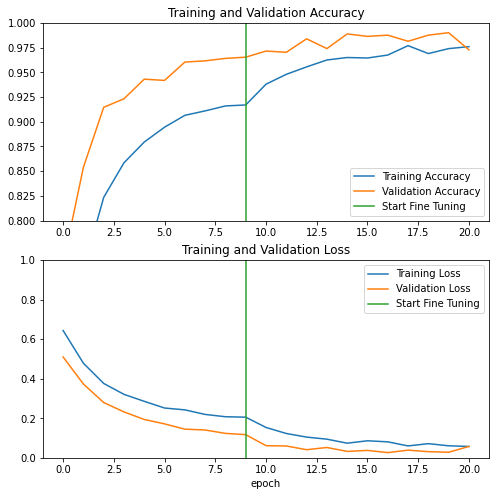

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 1s - loss: 0.0057 - accuracy: 1.0000

3/6 [==============>...............] - ETA: 0s - loss: 0.0179 - accuracy: 0.9896

5/6 [========================>.....] - ETA: 0s - loss: 0.0360 - accuracy: 0.9812

6/6 [==============================] - 0s 30ms/step - loss: 0.0339 - accuracy: 0.9792


Test accuracy : 0.9791666865348816


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1]
Labels:
 [1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1]


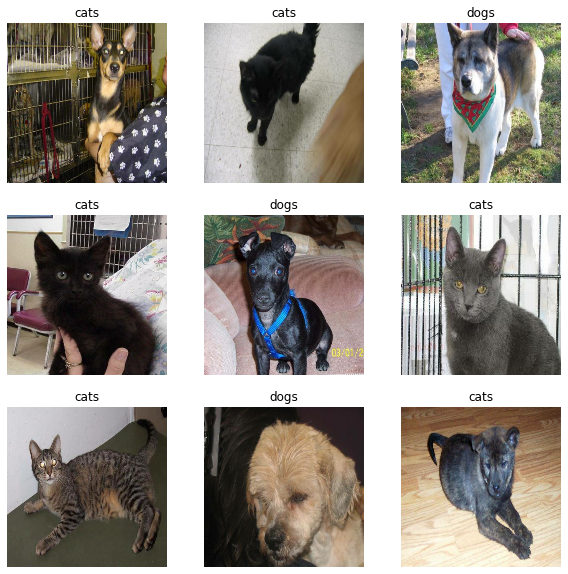

In [37]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
